# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
# %pip install scikit-survival
# %pip install scikitlearn
# %pip install lifelines
# %pip install tensorflow
# %pip install keras
# %pip install scikit-learn

# magic functions for Jupyter notebooks
# %matplotlib inline


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

# Import your chosen model
import sksurv

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times


from sklearn.pipeline import make_pipeline





2025-07-03 12:46:19.446974: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 12:46:19.465861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 12:46:19.731896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-03 12:46:19.883521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751546780.038971    1636 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751546780.10

## Model Selection: Survival Analysis

[Discuss the type(s) of models you consider for this task, and justify the selection.]

As one of the main goals is to predict the overall survival of AML-patients, the decision of a baseline-Model fell on building a survival Analysis model.

A survival Analysis model (build with scikit-survival sksurv) is a special kind of analysis. The Cox's proportional hazards model is kind of similar to regression but takes the cumulative hazards function in the presence of addidional covariants into account.
The Survival analysis describes a time-to event regression problem which is different to a regular regression due to "censoring". 

### Censoring
Censored data can occur as right censoring (event was not observed in timeframe), left censoring (event occured before start of the timeframe of a study) or interval censoring (event occured in an roughly described time interval, but the exact time is unknown)

The dataset of Acute Myeloic Leukemia (AML) patients contains medical and biological data, as well as a status of "alive" or "dead" on the last follow-up. The dataset is affected by "right censoring", which indicates that not every patient made it to the endpoint of data collection or didn't experience the "event" while the duration of the observation- timeframe. The left censoring also affects the given dataset, as some patients probably died before or right at the start of the observation timeframe. 

(For the application of the survival analysis with the scikit-survival package, some more tailored steps of data processing are required, compared to the regular processing of most other modelling packages. This means, the categorical data has to be encoded by usage of the One hot Encoder and the data hast to be compiled to arrays then, to run the survival analysis.)




In [3]:
# load data and preview

import os

os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")

print(os.getcwd())

# Load the datasets

# Clinical Data

cln_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv"
)  # clinical_train
cln_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv"
)  # clinical_test

# Molecular Data
maf_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv"
)  # molecular_train
maf_eval = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv"
)  # molecular_test

# Target Data (Outcome)
target_df = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv"
)  # target_train
target_df_test = pd.read_csv(
    "/workspaces/PredictLeukemiaSurvival/ChallengeData/random_submission_FRacdcw_v9kP4pP.csv"
)  # target_test risk scores

/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics


In [4]:
# Preview the data

## Clinical

# number of rows and columns
print("Clinical Data Rows: ", cln_df.shape[0])
print("Clinical Data Columns: ", cln_df.shape[1])
print("Clinical Data Head: ", cln_df.head())

## Molecular

# number of rows and columns
print("Molecular Data Rows: ", maf_df.shape[0])
print("Molecular Data Columns: ", maf_df.shape[1])
print("Molecular Data Head: ", maf_df.head())

## Target

# number of rows and columns
print("Target Data Rows: ", target_df.shape[0])
print("Target Data Columns: ", target_df.shape[1])
print("Target Data Head: ", target_df.head())

Clinical Data Rows:  3173
Clinical Data Columns:  9
Clinical Data Head:          ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS  
0      46,xy,del(20)(q12)[2]/46,xy[18]  
1                                46,xx  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  
Molecular Data Rows:  10785
Molecular Data Columns:  11
Molecular Data Head:          ID CHR        START          END                REF ALT    GENE  \
0  P100000  11  119149248.0  119149248.0                  G   A     CBL   
1  P100000   5  131822301.0  131822301.0          

In [5]:
# show min and max OS_YEARS of the target data
print("In target_df: ", "Min OS_YEARS:", target_df["OS_YEARS"].min())
print("In target_df: " "Max OS_YEARS:", target_df["OS_YEARS"].max())


In target_df:  Min OS_YEARS: 0.0
In target_df: Max OS_YEARS: 22.0438356164384


## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]

## Selection of Features

The overall survival prediction will be based on the generation of a risk score through the evaluation of the status (alive or dead) OS_STATUS, as event indicator and with the time measurements of survival in years OS_YEARS after last follow-up as time variable.

One of he main obstacles in working with censored data is choosing an unbiased estimator of the survival curve. There are different approaches like the Kaplan-Meyer survival probability.

Feature selection could be done randomly, or by differentiation of weighting risk-factors which would be highly desired in health-related fields.

Some main features of AML described in literature are the presence of blast cells in percentage (column 'BM_BLAST'), low concentration of Hemoglobine levels, resulting in anemia (column 'HB') as well as low levels of platelets (column 'PLT').




In [6]:
# Data preparation

# Convert 'OS_YEARS' to numeric
target_df["OS_YEARS"] = pd.to_numeric(target_df["OS_YEARS"], errors="coerce")

# Convert 'OS_STATUS' to boolean (1 for event, 0 for censored)
target_df["OS_STATUS"] = target_df["OS_STATUS"].astype(bool)
print(target_df[["OS_YEARS", "OS_STATUS"]].dtypes)


# Select features in clinical data
features = ["BM_BLAST", "HB", "PLT"]

# Select target in target data
target = ["OS_YEARS", "OS_STATUS"]



OS_YEARS     float64
OS_STATUS       bool
dtype: object


In [7]:

# Create the survival data format required for the model

X = cln_df.loc[cln_df["ID"].isin(target_df["ID"]), features]
y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

# Check shapes and types before splitting
print(y.shape, type(y))
print(len(y))

print(X.shape, type(X))
print(len(X))
print(X.dtypes)  # y has no .dtypes, its an numpy array


# Split the data into train and test sets
# usage of stratify to ensure balanced distribution of censored data in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y["OS_STATUS"], random_state=0
)

(3173,) <class 'numpy.ndarray'>
3173
(3173, 3) <class 'pandas.core.frame.DataFrame'>
3173
BM_BLAST    float64
HB          float64
PLT         float64
dtype: object


In [8]:
# create different types of data storage for differet requirements
# X_train
X_train_df = pd.DataFrame(X_train)
X_train_np = X_train.to_numpy()

# y_train
y_train_df = pd.DataFrame(y_train)
y_train_np = y_train
print(type(y_train_np))  # numpy array
# X_test
X_test_df = pd.DataFrame(X_test)
X_test_np = X_test.to_numpy()   
# y_test
y_test_df = pd.DataFrame(y_test)
y_test_np = y_test
print(type(y_test_np))  # numpy array

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
# show distribution of censored data in both train and test sets
# show number of counted patiens with event occurence in train data:
print(
    "Number of events in train data (y_train):",
    y_train["OS_STATUS"].sum(),
    ", Distribution: " ",",
    round(y_train["OS_STATUS"].sum() / len(y_train) * 100, 2),
    "%",
)
# show number of counted patiens with event occurence in test data:
print(
    "Number of events in test data (y_test):",
    y_test["OS_STATUS"].sum(),
    ", Distribution: " ",",
    round(y_test["OS_STATUS"].sum() / len(y_test) * 100, 2),
    "%",
)

Number of events in train data (y_train): 1280 , Distribution: , 50.43 %
Number of events in test data (y_test): 320 , Distribution: , 50.39 %


In [10]:
# Check the number of events in the target data

# Group by OS_STATUS and count number of events
target_df_events = target_df.groupby("OS_STATUS")["OS_STATUS"].count()

pct_target_df_events = (
    target_df.groupby("OS_STATUS")["OS_STATUS"].count() / len(target_df) * 100
).round(1)


# Print the number of events, if true print "number of deaths", if false print "number of censored"
for events, count in target_df_events.items():
    if events == True:
        print(
            "Number of deaths:",
            count,
            ",",
            pct_target_df_events[True],
            "%",
            "in target_df",
        )
    else:
        print(
            "Number of survivors:",
            count,
            ",",
            pct_target_df_events[False],
            "%",
            "in target_df",
        )

# Show the total number of samples in the target data

print("Total number of samples:", len(target_df))

Number of survivors: 1573 , 49.6 % in target_df
Number of deaths: 1600 , 50.4 % in target_df
Total number of samples: 3173


The target_df dataframe consists of a total of 3323 patients. For 1750 patients, which equals 52.7 %, the occurence of the event "death" can be observed, whereas 1573 patients, which equals 47.3 % survive at least until the endpoint of data collection.

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]

One of the main used models for survival predictions in the medical field is the Cox's proportional hazards model.

#### Survival function: S(t) 
- probability of an individual to survive longer than an specific time t:

$$S(t)=P(T > t)$$ 


#### Hazard function
- quantification of a risk of event occurence within a short time interval, when the individual lives up to a known time  t.

#### Cumulative hazard function
- the cumulative risk of occurence of an event up to the time t. 

#### Probability density function of survival time
- the probability of individuals to survive a short time interval.

In the recent years, several Machine Learning survival algorithms have been developed to handle complex and cencored time-to-event data. One of the established algorithms is named random survival forests

## Implementation

[Implement the final model(s) you've selected based on the above steps.]




### Kaplan - Meier unconditional survival analysis
This method approaches the problem of estimatiobn of time-to-event from cecored data
The Kaplan - Meier curve shows the overall survival propability which is changing over time. At the start of the data collection it is close to one and almost all of the patients are still alive. Over time, the probability of survival decreases gradually due to the occurences of the event "death".

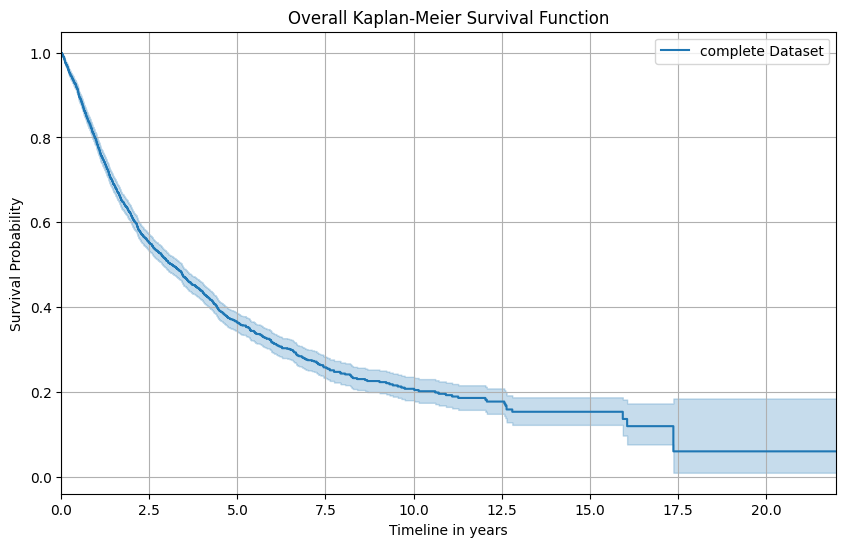

In [11]:
# Overall Survival Analysis Kaplan Meier Curve
kmf = KaplanMeierFitter()

kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Overall Kaplan-Meier Survival Function")
plt.legend(["complete Dataset"])
plt.grid(True)
# plt.tight_layout()
plt.show()

In [12]:
# get survival probability at 10 years for the complete dataset
kmf.predict(10)
# get survival probability at 3, 5, 7 years for the complete dataset
kmf.predict([3, 5, 7])




3    0.509264
5    0.363721
7    0.274511
Name: KM_estimate, dtype: float64

In [13]:
from lifelines.utils import median_survival_times
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("Median Survival Time:", median_)
print("Median Survival Time Confidence Interval:", median_confidence_interval_)

Median Survival Time: 3.14520547945205
Median Survival Time Confidence Interval:      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                2.871233                3.424658


In [14]:
kmf = KaplanMeierFitter()

# fit the Kaplan-Meier curve and keep ID column but ignore string format


kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])

pat_kmf = kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])
print(pat_kmf.median_survival_time_)
print(pat_kmf.survival_function_)


3.14520547945205
           KM_estimate
timeline              
0.000000      1.000000
0.002740      0.999679
0.005479      0.999679
0.008219      0.999037
0.010959      0.999037
...                ...
16.389041     0.118853
16.567123     0.118853
17.147945     0.118853
17.375342     0.059427
22.043836     0.059427

[1653 rows x 1 columns]


In [15]:
#convert pat_kmf to a dataframe
pat_kmf_df = pd.DataFrame(pat_kmf.survival_function_)
pat_kmf_df.head(10)

,KM_estimate
timeline,
0.000000,1.000000
0.002740,0.999679
0.005479,0.999679
0.008219,0.999037
0.010959,0.999037
0.016438,0.998716
0.019178,0.998716
0.021918,0.998072
0.024658,0.997750


In [16]:
# ...existing code...
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])

# Assign the KM estimate for each patient's observed time
nw_kme_df = target_df.reset_index(drop=True)  # Ensure unique index
# print nw_kme_df
nw_kme_df.head(10)

,ID,OS_YEARS,OS_STATUS
0,P132697,1.115068,True
1,P132698,4.928767,False
2,P116889,2.043836,False
3,P132699,2.476712,True
4,P132700,3.145205,False
5,P132701,2.013699,True
6,P132702,0.810959,False
7,P132703,1.849315,True
8,P132704,1.005479,True
9,P132705,0.293151,False


In [17]:

# sort the dataframe by OS_YEARS
#nw_kme_df = nw_kme_df.sort_values("OS_YEARS")

# create new column for KM estimate but leave it empty
nw_kme_df["KM_estimate"] = ""

# loop through the dataframe and assign the KM estimate to each row if timeline matches OS_YEARS
for index, row in nw_kme_df.iterrows():
    if row["OS_YEARS"] in pat_kmf_df.index:
        nw_kme_df.at[index, "KM_estimate"] = pat_kmf_df.loc[row["OS_YEARS"]]["KM_estimate"]
    else:
        nw_kme_df.at[index, "KM_estimate"] = None

# save the dataframe to a csv file
nw_kme_df.to_csv("nw_kme_df.csv", index=False)


print(nw_kme_df.head(20))

         ID  OS_YEARS  OS_STATUS KM_estimate
0   P132697  1.115068       True    0.760912
1   P132698  4.928767      False    0.366431
2   P116889  2.043836      False    0.606791
3   P132699  2.476712       True    0.553127
4   P132700  3.145205      False    0.499849
5   P132701  2.013699       True    0.611145
6   P132702  0.810959      False    0.831455
7   P132703  1.849315       True    0.636084
8   P132704  1.005479       True    0.787818
9   P132705  0.293151      False    0.944263
10  P132707  0.643836       True    0.865557
11  P106361  1.473973       True    0.691273
12  P132708  1.260274      False    0.735083
13  P132709  1.054795       True    0.776342
14  P106410  4.608219      False    0.384589
15  P132710  1.980822      False    0.617648
16  P132711  1.482192       True    0.690043
17  P103899  2.884932       True    0.518413
18  P132712  2.347945      False    0.564754
19  P132713  0.101370       True    0.979778


In [18]:
from lifelines.utils import covariates_from_event_matrix

# convert dataframe of target_df to event matrix
cv = covariates_from_event_matrix(target_df, id_col= "ID")
print(cv)   
#kmf_target_df = 

           ID  duration  OS_STATUS  OS_YEARS
0     P100000  0.000000        1.0       0.0
1     P100000  5.819178        0.0       1.0
2     P100001  0.000000        1.0       0.0
3     P100001  2.857534        0.0       1.0
4     P100002  0.306849        0.0       1.0
...       ...       ...        ...       ...
6285  P132727  0.578082        0.0       1.0
6286  P132728  1.000000        1.0       0.0
6287  P132728  1.284932        0.0       1.0
6288  P132729  0.000000        1.0       0.0
6289  P132729  2.117808        0.0       1.0

[6290 rows x 4 columns]


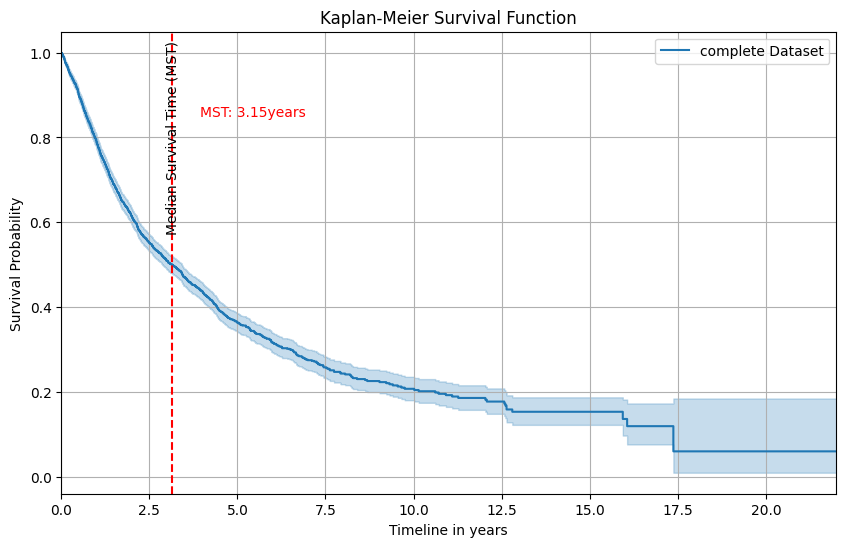

In [19]:
#plot with line of median survival time
kmf = KaplanMeierFitter()

kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])


plt.figure(figsize=(10, 6))
kmf.plot()
plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["complete Dataset"])
plt.grid(True)
# add median survival time to the plot
plt.axvline(median_, color='red', linestyle='--')
plt.text(median_, 0.8, "Median Survival Time (MST)", rotation=90, ha="center", va="center")
# print median survival time next to the line
plt.text(median_ + 0.8, 0.85, "MST: " + str(round(median_, 2)) + "years", color='red')
# plt.tight_layout()
plt.show()

<class 'numpy.ndarray'> (2538,)
<class 'numpy.ndarray'> (635,)


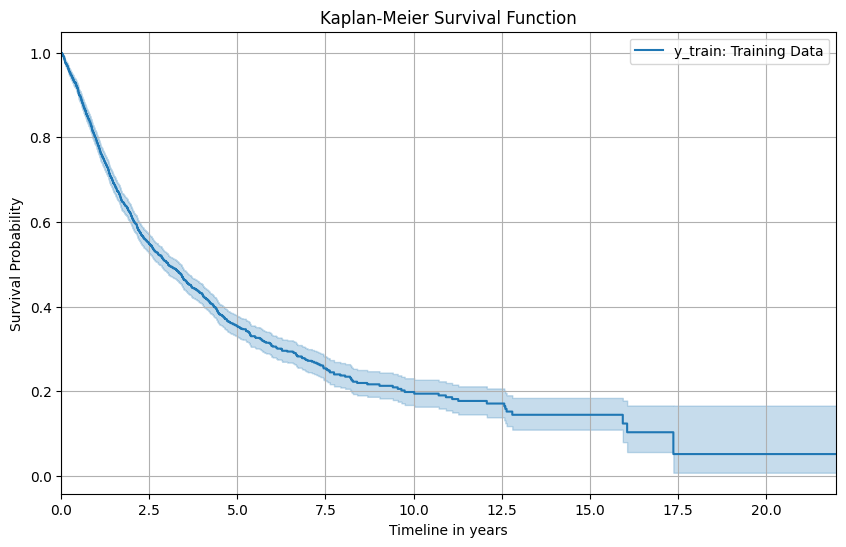

In [20]:
print(type(y_train), y_train.shape)
print(type(y_test), y_test.shape)


# Import the Kaplan-Meier fitter from lifelines

#from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()


# Apply Kaplan-Meier survival analysis to training data

# Fit the Kaplan-Meier estimator to the training data
# y_train is a structured array with 'OS_YEARS' and 'OS_STATUS'
# 'OS_YEARS' is the time to event or censoring, 'OS_STATUS

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])

# Plot the kaplan-meier survival function of training data
# set x axis max to 22 years (max survival time in the dataset)


plt.figure(figsize=(10, 6))
kmf.plot()
plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_train: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()


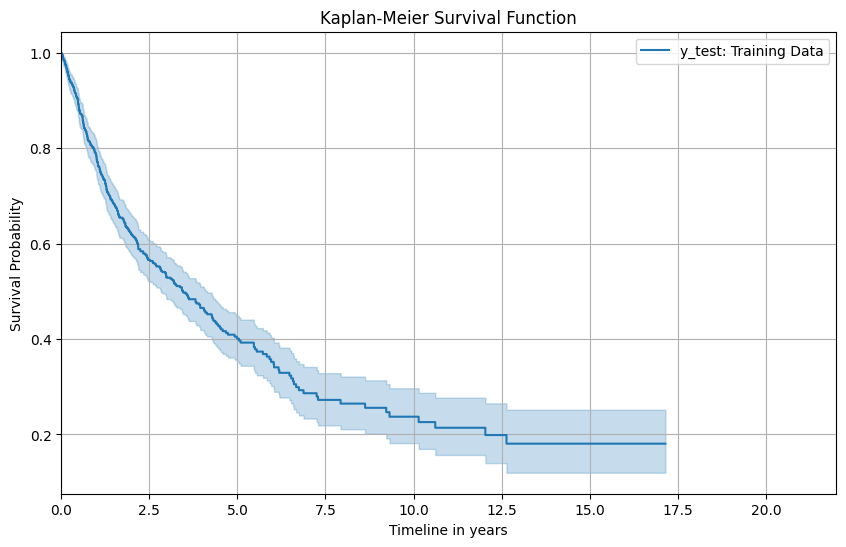

In [21]:
# Apply Kaplan-Meier survival analysis to test data

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])

# Plot the kaplan-meier survival function of test data

plt.figure(figsize=(10, 6))
kmf.plot()

plt.xlim(0, 22)
plt.xlabel("Timeline in years")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Function")
plt.legend(["y_test: Training Data"])
plt.grid(True)
# plt.tight_layout()
plt.show()

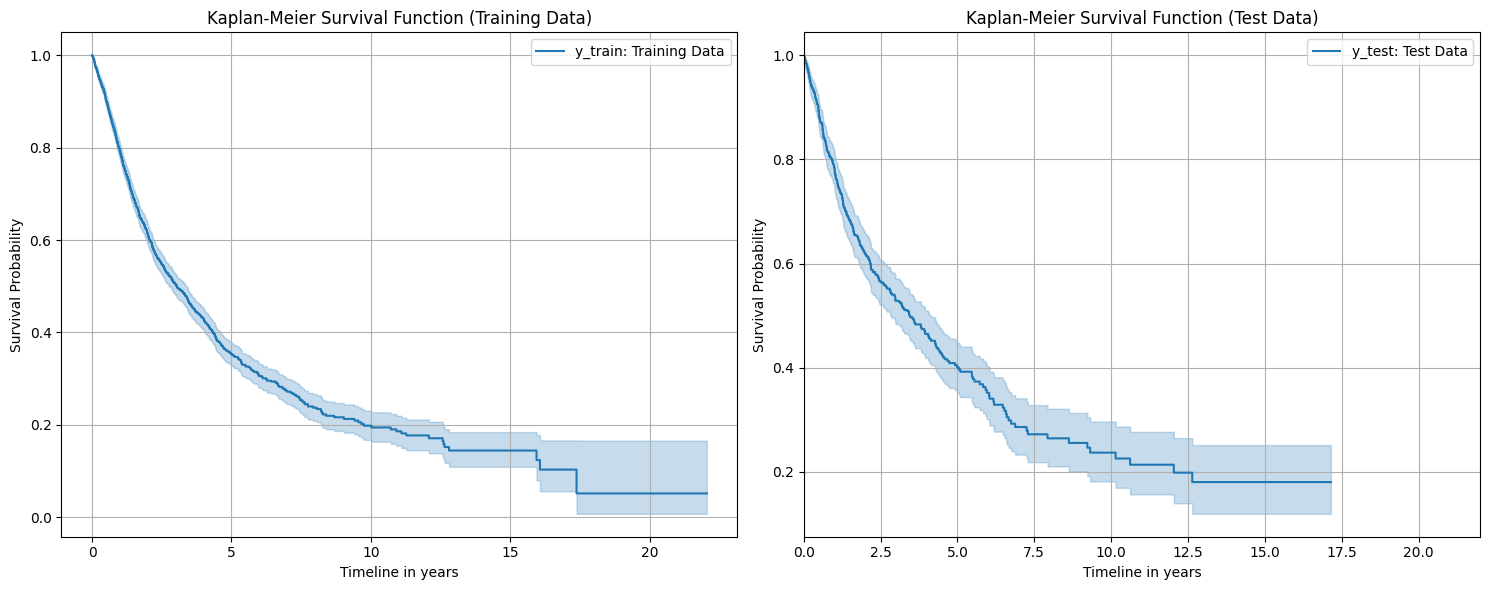

In [22]:
# plot the kaplan-meier survival function of training and test data next to each other

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
kmf.plot(ax=ax[0])
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)

plt.xlim(0, 22)
plt.tight_layout()
plt.show()

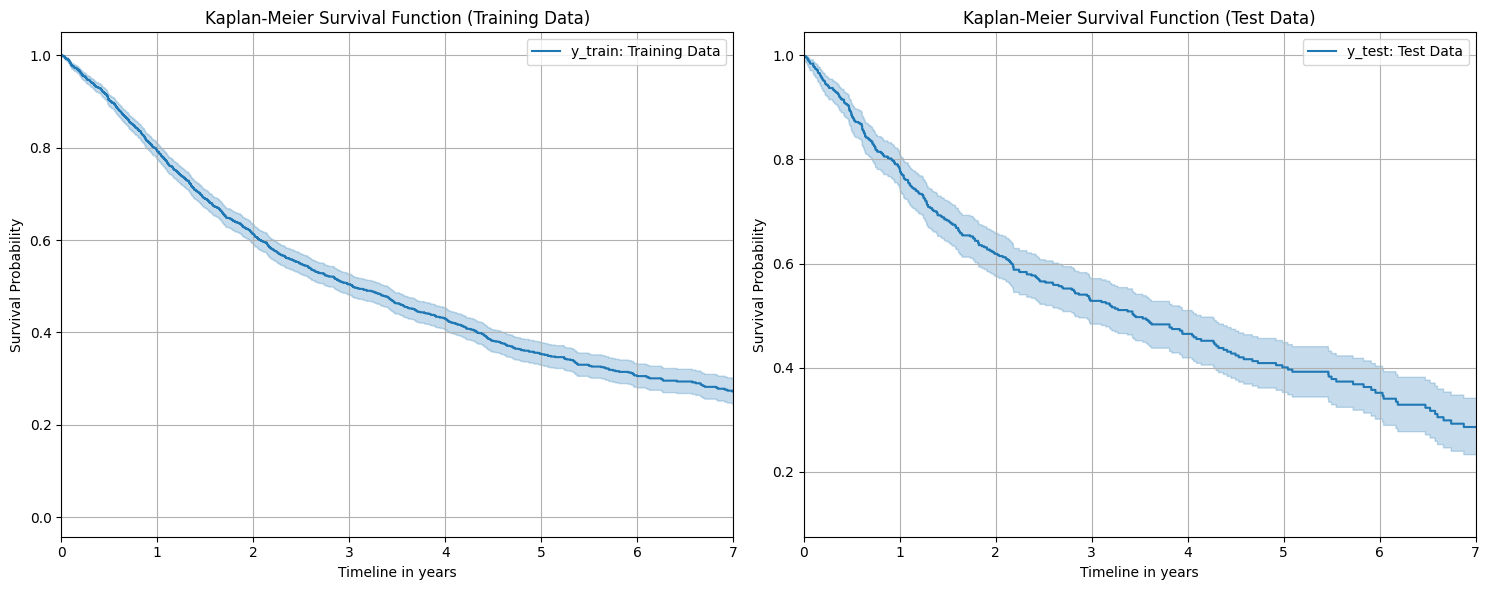

In [23]:
# Estimate the survival probability for a maximum of 7 years
max_years = 7

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])
kmf.plot(ax=ax[0])
# make the x-axis limit 7 years
ax[0].set_xlim(0, max_years)
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
# make the x-axis limit 7 years
ax[1].set_xlim(0, max_years)
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)


plt.tight_layout()
plt.show()

In [24]:
# print the survival probability for training data at 3 years

print("Survival probability for training data at 3 years:", round(kmf.predict(3),2))
print("Survival probability for training data at 5 years:", round(kmf.predict(5),2))
print("Survival probability for training data at 7 years:", round(kmf.predict(7),2))

Survival probability for training data at 3 years: 0.53
Survival probability for training data at 5 years: 0.4
Survival probability for training data at 7 years: 0.29


In [25]:
# print the survival probability at 1, 3, 5 years in percent


kmf.fit(target_df["OS_YEARS"], target_df["OS_STATUS"])


print("Survival probability at 1 year:", round(kmf.predict(1) * 100,2), "%")
print("Survival probability at 3 years:", round(kmf.predict(3) * 100,2), "%")
print("Survival probability at 5 years:", round(kmf.predict(5) * 100,2), "%")
#print("Survival probability at 7 years:", round(kmf.predict(7) * 100,2), "%")




Survival probability at 1 year: 78.97 %
Survival probability at 3 years: 50.93 %
Survival probability at 5 years: 36.37 %


<Axes: xlabel='timeline'>

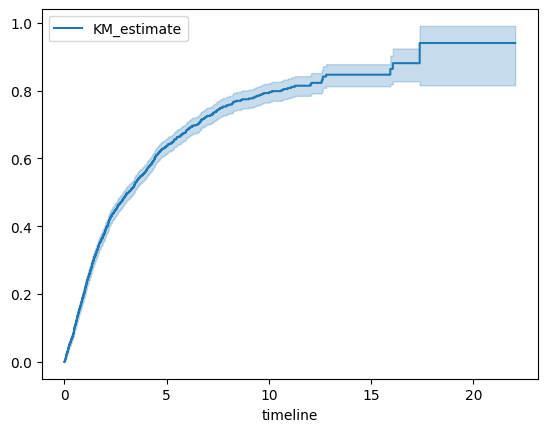

In [26]:
# Plot cumulative density (the inversed survival function) for training and test data
kmf.plot_cumulative_density()

In [27]:
# addition of median survival time
## Return the unique time point, t, such that S(t) = 0.5. This is the "half-life" of the population, 
## and a robust summary statistic for the population

median_survival_time = kmf.median_survival_time_
print("Median Survival Time kmf:", median_survival_time)

#median_survival_time_days = median_survival_times(pd.DataFrame(y_train["OS_YEARS"]))

# median survival time in years
y_test_mst_y = y_test_df["OS_YEARS"].median()
#print("y_test Median Survival Time in years:", round(y_test_mst_y, 2), "years")

#median_survival_time_days = median_survival_times((y_train_df["OS_YEARS"]))
y_test_mst_d = y_test_mst_y * 365  # Convert years to days
#print("y_test Median Survival Time in days:", round(y_test_mst_d, 2), "days")

# Median survival time in months
y_test_mst_m = y_test_mst_d / 30
#print("y_test Median Survival Time in months:", round(y_test_mst_m, 2), "months")



# median survival time in years
y_train_mst_y = y_train_df["OS_YEARS"].median()
#print("y_train Median Survival Time in years:", round(y_train_mst_y, 2), "years")

#median_survival_time_days = median_survival_times((y_train_df["OS_YEARS"]))
y_train_mst_d =  y_train_mst_y * 365  # Convert years to days
#print("y_train Median Survival Time in days:", round(y_train_mst_d, 2), "days")

# Median survival time in months
y_train_mst_m = y_train_mst_y / 30
#print("y_train Median Survival Time in months:", round(y_train_mst_m, 2), "months")


# print the median survival time in years, days and months for both training and test data
print("Median Survival Time (MST) in years:")
print("y_train:", round(y_train_mst_y, 2), "years")
print("y_test:", round(y_test_mst_y, 2), "years")

print("Median Survival Time (MST) in days:")
print("y_train:", round(y_train_mst_d, 2), "days")
print("y_test:", round(y_test_mst_d, 2), "days")

print("Median Survival Time (MST) in months:")
print("y_train:", round(y_train_mst_m, 2), "months")
print("y_test:", round(y_test_mst_m, 2), "months")




# average survival time in years
y_train_avg_y = y_train_df["OS_YEARS"].mean()
y_test_avg_y = y_test_df["OS_YEARS"].mean()
print("Average Survival Time (AST) in years:", 
      "y_train:", round(y_train_avg_y, 2), "years",
      ", y_test:", round(y_test_avg_y, 2), "years")

Median Survival Time kmf: 3.14520547945205
Median Survival Time (MST) in years:
y_train: 1.65 years
y_test: 1.73 years
Median Survival Time (MST) in days:
y_train: 600.5 days
y_test: 631.0 days
Median Survival Time (MST) in months:
y_train: 0.05 months
y_test: 21.03 months
Average Survival Time (AST) in years: y_train: 2.43 years , y_test: 2.67 years


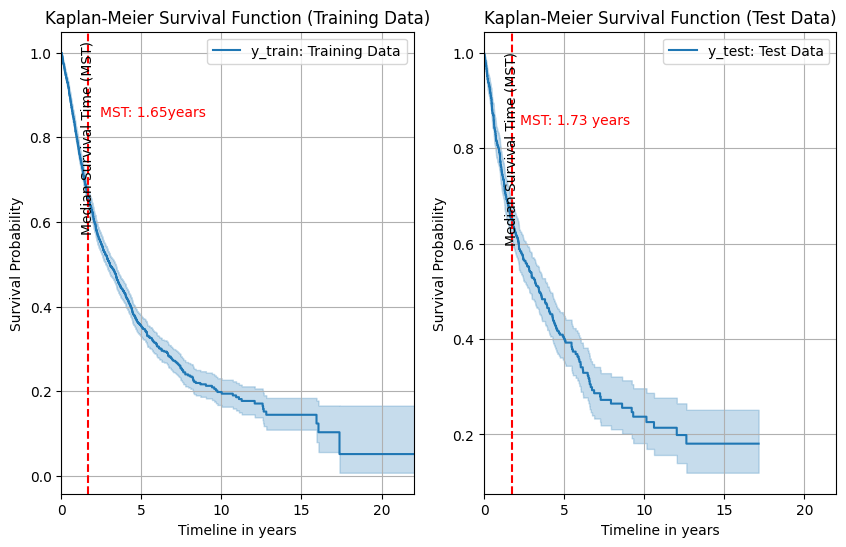

In [28]:
# plot kaplan meier survival function with MST lines

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

kmf.fit(y_train["OS_YEARS"], y_train["OS_STATUS"])


kmf.plot(ax=ax[0])
# make the x-axis limit 22 years
ax[0].set_xlim(0, 22)
ax[0].set_title("Kaplan-Meier Survival Function (Training Data)")
ax[0].set_xlabel("Timeline in years")
ax[0].set_ylabel("Survival Probability")
ax[0].legend(["y_train: Training Data"])
ax[0].grid(True)
# add median survival time to the plot
ax[0].axvline(y_train_mst_y, color='red', linestyle='--')
ax[0].text(y_train_mst_y, 0.8, "Median Survival Time (MST)", rotation=90, ha="center", va="center")
# print median survival time next to the line
ax[0].text(y_train_mst_y + 0.8, 0.85, "MST: " + str(round(y_train_mst_y, 2)) + "years", color='red')

kmf.fit(y_test["OS_YEARS"], y_test["OS_STATUS"])
kmf.plot(ax=ax[1])
# make the x-axis limit 22 years
ax[1].set_xlim(0, 22)
ax[1].set_title("Kaplan-Meier Survival Function (Test Data)")
ax[1].set_xlabel("Timeline in years")
ax[1].set_ylabel("Survival Probability")
ax[1].legend(["y_test: Test Data"])
ax[1].grid(True)
# add median survival time to the plot
ax[1].axvline(y_test_mst_y, color='red', linestyle='--')
ax[1].text(y_test_mst_y, 0.8, "Median Survival Time (MST)", rotation=90, ha="center", va="center")
# print median survival time next to the line
plt.text(y_test_mst_y + 0.5, 0.85, "MST: " + str(round(y_test_mst_y, 2)) + " years", color='red')

#plt.xlim(0, 22)
#plt.tight_layout()
plt.show()

In [29]:
# median survival time and confidence interval by library lifelines functions

kmf.median_survival_time_, kmf.confidence_interval_


(np.float64(3.45753424657534),
            KM_estimate_lower_0.95  KM_estimate_upper_0.95
 0.000000                 1.000000                1.000000
 0.002740                 0.988768                0.999776
 0.005479                 0.988768                0.999776
 0.010959                 0.988768                0.999776
 0.021918                 0.987306                0.999201
 ...                           ...                     ...
 14.747945                0.119702                0.251629
 15.010959                0.119702                0.251629
 15.797260                0.119702                0.251629
 16.172603                0.119702                0.251629
 17.147945                0.119702                0.251629
 
 [546 rows x 2 columns])

In [30]:
# create new dataframe with filtered sex?
# create a new csv file with added column for sex based on the new dataframe
# if in the column cytogenetics appears xx anywhwere, then the patient is female =1 anf if there is xy anywhere, then the patient is male = 0
# scan "Cytogenetics" column for "xx" or "xy" of cln_df 

nw_cln_df = cln_df
# add a new column for "sex" but leave it empty
nw_cln_df["Sex"] = ""


print(nw_cln_df.head())


        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]      
1                                46,xx      
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]      
3    46,xy,del(3)(q26q27)[15]/46,xy[5]      
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]      


In [31]:


# scan CYTOGENETICS column for "xx" or "xy", ignore the rest 

# if "xx" appears anywhere in the column, then the patient is female


nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xx", case=True), "Sex"] = "Female"

# if "xy" appears anywhere in the column, then the patient is male
nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xy", case=True), "Sex"] = "Male"

# if we don't find "xx" or "xy" anywhere in the column, then the patient is unknown
nw_cln_df.loc[(nw_cln_df["CYTOGENETICS"].str.contains("xx", case=True) == False) & (nw_cln_df["CYTOGENETICS"].str.contains("xy", case=True) == False), "Sex"] = "Unknown"

print(nw_cln_df.head())


        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS     Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]    Male  
1                                46,xx  Female  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]    Male  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]    Male  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  Female  


In [32]:
# count the number of females = 1 and males = 0

nw_cln_df["Sex"].value_counts() 

Sex
Male       1998
Female     1079
Unknown      96
Name: count, dtype: int64

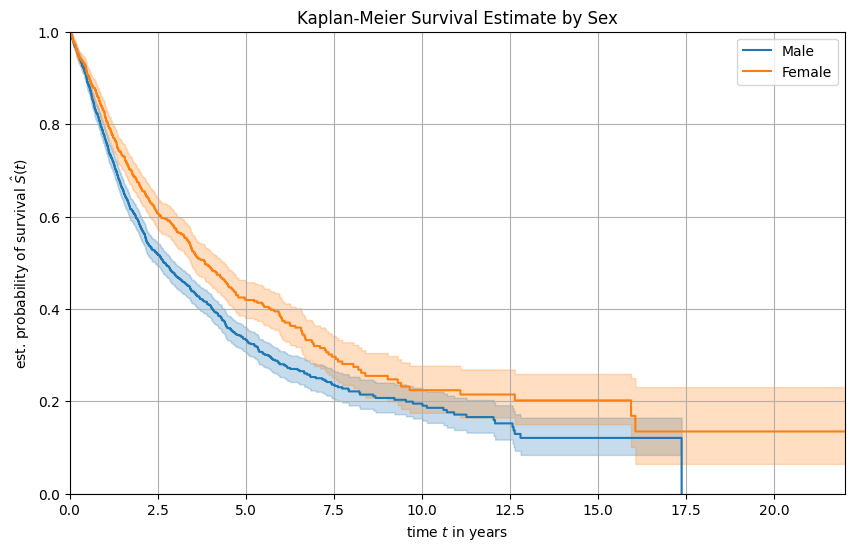

In [33]:
# without unknown
# create kaplan meier estimates by sex

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

for sex in ["Male", "Female"]:
    mask_sex = nw_cln_df["Sex"] == sex
    durations = target_df.loc[mask_sex, "OS_YEARS"]
    events = target_df.loc[mask_sex, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=sex)
    kmf.plot_survival_function(ci_show=True)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\\hat{S}(t)$")
plt.xlabel("time $t$ in years")
plt.title("Kaplan-Meier Survival Estimate by Sex")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 22)
plt.show()

In [34]:
# plot statistics for KM estimates by sex
from lifelines.utils import median_survival_times

kmf = KaplanMeierFitter()

for sex in ["Male", "Female"]:
    mask = nw_cln_df["Sex"] == sex
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events)
    median_survival_times = kmf.median_survival_time_
    print(f"Median Survival Time for {sex}: {median_survival_times}")   



Median Survival Time for Male: 2.68767123287671
Median Survival Time for Female: 3.84931506849315


In [35]:
# convert BLAST, HB and PLT to numeric values

nw_cln_df["BM_BLAST"] = pd.to_numeric(nw_cln_df["BM_BLAST"], errors="coerce")
nw_cln_df["HB"] = pd.to_numeric(nw_cln_df["HB"], errors="coerce")
nw_cln_df["PLT"] = pd.to_numeric(nw_cln_df["PLT"], errors="coerce")

print(nw_cln_df.head())

        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS     Sex  
0      46,xy,del(20)(q12)[2]/46,xy[18]    Male  
1                                46,xx  Female  
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]    Male  
3    46,xy,del(3)(q26q27)[15]/46,xy[5]    Male  
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  Female  


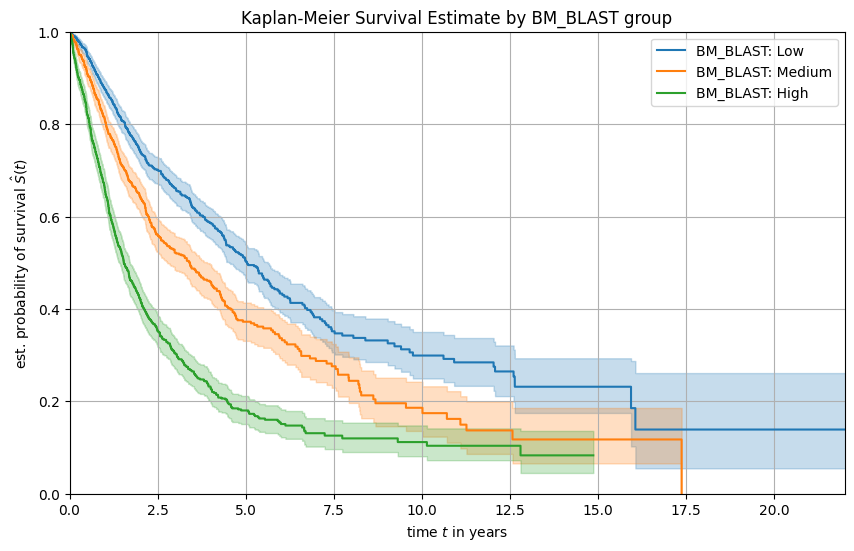

In [36]:
# create kaplan meier estimates by BM_BLAST
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))


nw_cln_df["BM_BLAST_group"] = pd.qcut(nw_cln_df["BM_BLAST"], 3, labels=["Low", "Medium", "High"])

for group in ["Low", "Medium", "High"]:
    mask = nw_cln_df["BM_BLAST_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=f"BM_BLAST: {group}")
    kmf.plot_survival_function(ci_show=True)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\\hat{S}(t)$")
plt.xlabel("time $t$ in years")
plt.title("Kaplan-Meier Survival Estimate by BM_BLAST group")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 22)
plt.show()


In [37]:
# save code for kaplan meier estimates by BM_BLAST in a variable
from lifelines import KaplanMeierFitter




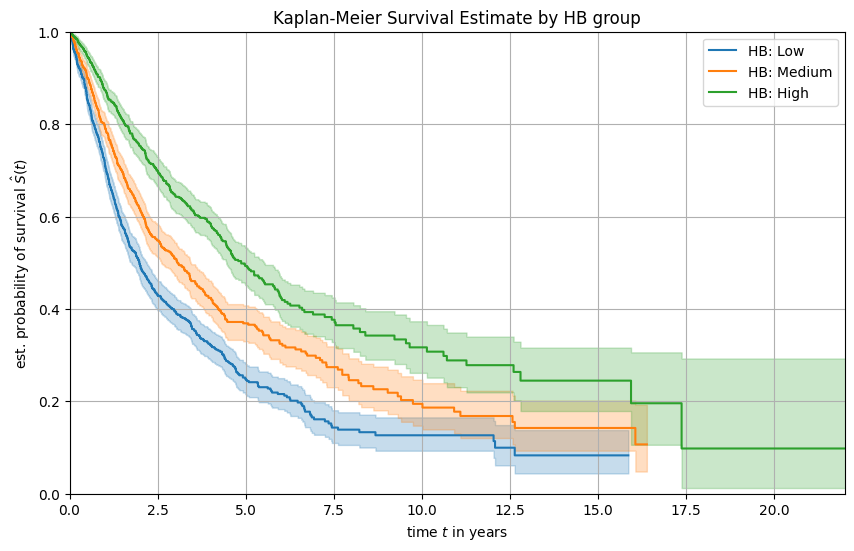

In [38]:
# create Kaplan Meier estimates by HB
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Example for HB split into tertiles
nw_cln_df["HB_group"] = pd.qcut(nw_cln_df["HB"], 3, labels=["Low", "Medium", "High"])

for group in ["Low", "Medium", "High"]:
    mask = nw_cln_df["HB_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=f"HB: {group}")
    kmf.plot_survival_function(ci_show=True)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\\hat{S}(t)$")
plt.xlabel("time $t$ in years")
plt.title("Kaplan-Meier Survival Estimate by HB group")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 22)
plt.show()

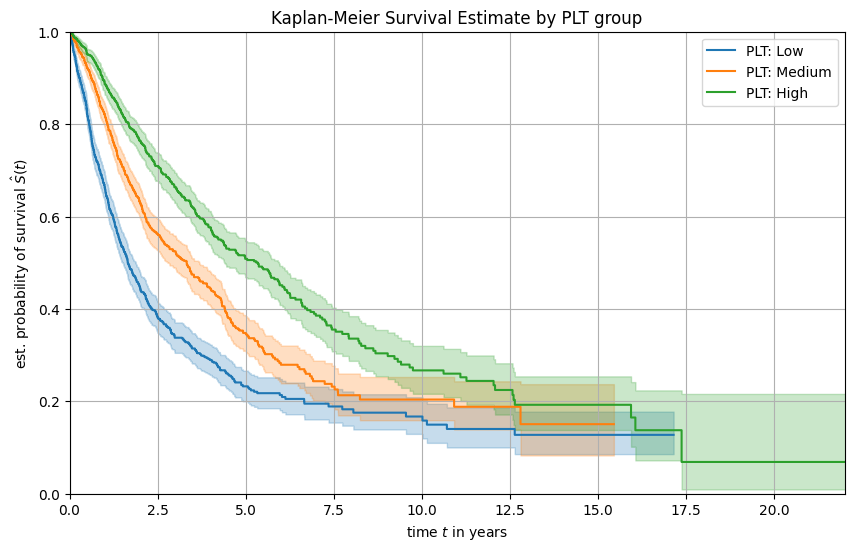

In [39]:
# KM estimates by PLT
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Example for PLT split into tertiles
nw_cln_df["PLT_group"] = pd.qcut(nw_cln_df["PLT"], 3, labels=["Low", "Medium", "High"])

for group in ["Low", "Medium", "High"]:
    mask = nw_cln_df["PLT_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=f"PLT: {group}")
    kmf.plot_survival_function(ci_show=True)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\\hat{S}(t)$")
plt.xlabel("time $t$ in years")
plt.title("Kaplan-Meier Survival Estimate by PLT group")
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 22)
plt.show()

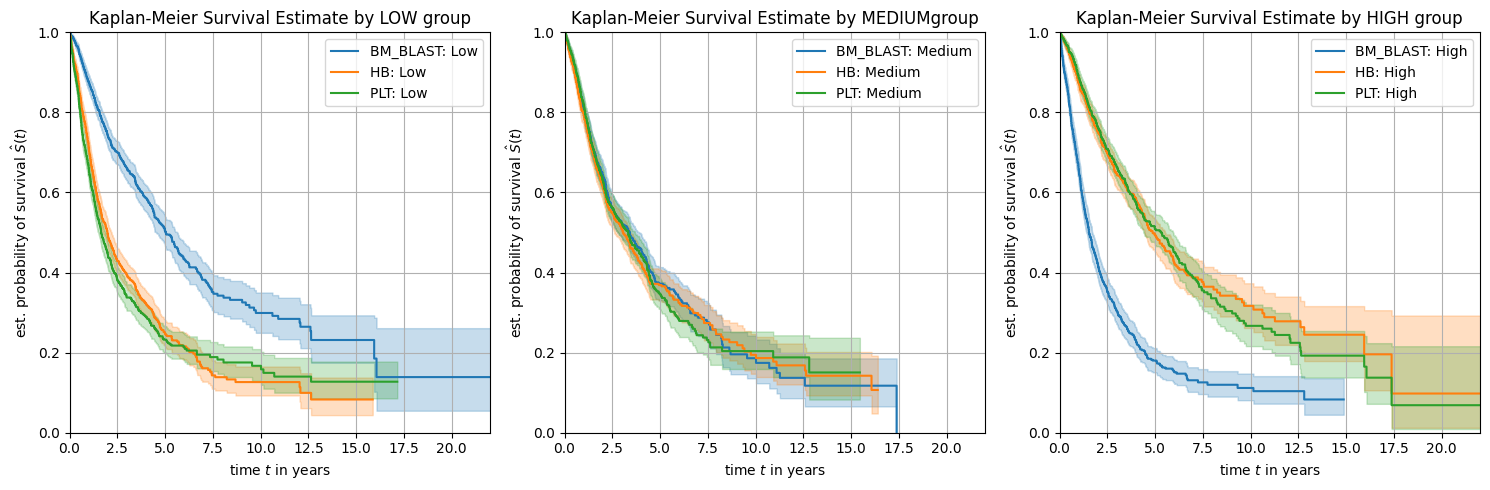

In [40]:
# plot survival plots of grouped BM_BLAST, HB and PLT in subplots in one figure

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, group in enumerate(["Low", "Medium", "High"]):
    mask = nw_cln_df[f"BM_BLAST_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=f"BM_BLAST: {group}")
    kmf.plot_survival_function(ax=axes[i], ci_show=True)

for i, group in enumerate(["Low", "Medium", "High"]):
    mask = nw_cln_df[f"HB_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]
    kmf.fit(durations=durations, event_observed=events, label=f"HB: {group}")
    kmf.plot_survival_function(ax=axes[i], ci_show=True)

for i, group in enumerate(["Low", "Medium", "High"]):
    mask = nw_cln_df[f"PLT_group"] == group
    durations = target_df.loc[mask, "OS_YEARS"]
    events = target_df.loc[mask, "OS_STATUS"]        
    kmf.fit(durations=durations, event_observed=events, label=f"PLT: {group}")
    kmf.plot_survival_function(ax=axes[i], ci_show=True)

#grids
for ax in axes:
    ax.grid(True)
    ax.set_xlim(0, 22)
    ax.set_ylim(0, 1)
    ax.set_ylabel("est. probability of survival $\\hat{S}(t)$")
    ax.set_xlabel("time $t$ in years")
    ax.legend(loc="best")
    ax.title.set_fontsize(11)

# set individual titles for each subplot
axes[0].set_title("Kaplan-Meier Survival Estimate by LOW group")
axes[1].set_title("Kaplan-Meier Survival Estimate by MEDIUMgroup")
axes[2].set_title("Kaplan-Meier Survival Estimate by HIGH group")
# adjust spacing between subplots
plt.tight_layout()
    
plt.show()

## Cox Proportional Hazards

### Multivariant Survival Model


In [41]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

from sksurv.metrics import concordance_index_ipcw


In [42]:
# create cox proportional hazards model


# Training features in X_train (dataframe)
cox_X_train = X_train_df

print(cox_X_train.shape)

# event/ time  columns in y_train (dataframe), but will be converted to structured array for survival analysis
cox_y_train = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_train_df)

print(cox_y_train.shape)

coxph = CoxPHSurvivalAnalysis()

# fit the cox proportional hazards model
coxph.fit(cox_X_train, cox_y_train)

(2538, 3)
(2538,)


CoxPHSurvivalAnalysis()

In [43]:
# cox coefficients
cox_coefficients = pd.DataFrame(coxph.coef_, index=cox_X_train.columns, columns=["coef"])
cox_coefficients["exp(coef)"] = np.exp(cox_coefficients["coef"])
cox_coefficients = cox_coefficients.sort_values("coef")
print("Cox Proportional Hazards Model Coefficients:\n", cox_coefficients, )  # get the coefficients and their standard errors

# standard error of the coefficients

Cox Proportional Hazards Model Coefficients:
               coef  exp(coef)
HB       -0.162277   0.850206
PLT      -0.002008   0.997994
BM_BLAST  0.031534   1.032036


The  cox model shows hazard ratios for every feature in relation to the other groups
coef is the estimated logarithm of the hazard ratio 
exp(coef) is the transformed log of the hazard ratio to the hazard ratio
A higher value indicates a higher risk

Therefore has the BM_BLAST value the highest impact as risk-predictor


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")  # displays text representation of estimators

In [45]:
# load data from dataset
X = nw_cln_df[["Sex"]]

y = Surv.from_dataframe("OS_STATUS", "OS_YEARS", target_df)

# for one-hot encoding
X = X.astype(str)

# set category type for one-hot encoding
X = X.astype("category")

# drop ID column
#X = X.drop("ID", axis=1)



In [46]:
# filepath: /workspaces/PredictLeukemiaSurvival/3_Model/clnd_Survival_analysis_model_MM.ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sksurv.metrics import concordance_index_ipcw
from sklearn.model_selection import GridSearchCV, KFold

def cindex_ipcw_scorer(estimator, X, y):
    pred = estimator.predict(X)
    # y is a structured array with ('event', 'time')
    result = concordance_index_ipcw(y, y, pred, tau=7)
    return result[0]  # The concordance index

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis())
gvc = GridSearchCV(
    pipe,
    {"coxnetsurvivalanalysis__l1_ratio": np.arange(0.1, 1.1, 0.1)},
    cv=KFold(5),
    scoring=cindex_ipcw_scorer,
    n_jobs=-1,
)


from sksurv.preprocessing import OneHotEncoder

# X should be your features DataFrame (e.g., X = X.astype(str) and drop ID if present)
Xt = OneHotEncoder().fit_transform(X)

gvc.fit(Xt, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('coxnetsurvivalanalysis',
                                        CoxnetSurvivalAnalysis())]),
             n_jobs=-1,
             param_grid={'coxnetsurvivalanalysis__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring=<function cindex_ipcw_scorer at 0x7e7dcc4f9ee0>)

In [47]:

# Now you can access the best parameters
print("Best parameters found:", gvc.best_params_)
# Save to a variable if needed
best_params = gvc.best_params_
# ...existing code...

Best parameters found: {'coxnetsurvivalanalysis__l1_ratio': np.float64(0.1)}


In [48]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gvc.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                        l1_ratio=np.float64(0.1)))])

In [49]:
#check column names afer one-hot encoding
Xt.columns


Index(['Sex=Male', 'Sex=Unknown'], dtype='object')

In [50]:

# check y column names

y




array([( True, 1.11506849), (False, 4.92876712), (False, 2.04383562), ...,
       (False, 1.99726027), ( True, 0.09589041), (False, 2.29041096)],
      dtype=[('OS_STATUS', '?'), ('OS_YEARS', '<f8')])

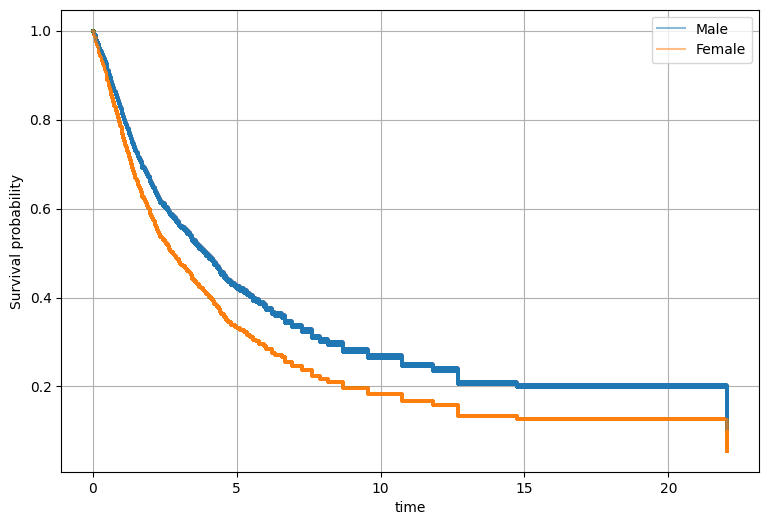

In [51]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

# timepoints are in y data


time_points = np.quantile(y["OS_YEARS"], np.linspace(0, 1, 200))

legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))

for fn, label in zip(surv_fns, Xt.loc[:, "Sex=Male"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    if len(legend_handles) == label:
        name = "Female" if label ==1 else "Male"
        legend_handles.append(line)
        legend_labels.append(name)

# place legend outside the plot

ax.legend(legend_handles, legend_labels)
#ax.set_xlim(0, 22)

ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [52]:
# import cox coefficients
cox_coefficients = coxph.coef_

X, y = cox_X_train, cox_y_train
X = X.astype(float)
estimator = CoxPHSurvivalAnalysis().fit(X,y)

# Predict the cumulative hazard function for each sample in the training set and save it
train_chf = estimator.predict_cumulative_hazard_function(X)
print(train_chf)  # Display the first few cumulative hazard functions


[StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.65671233e+01, 1.73753425e+01, 2.20438356e+01]), y=array([0.00000000e+00, 0.00000000e+00, 3.96336552e-03, ...,
        1.54655064e+01, 2.09692549e+01, 2.09692549e+01]), a=np.float64(0.18228563487137134), b=0.0)
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.65671233e+01, 1.73753425e+01, 2.20438356e+01]), y=array([0.00000000e+00, 0.00000000e+00, 3.96336552e-03, ...,
        1.54655064e+01, 2.09692549e+01, 2.09692549e+01]), a=np.float64(0.17750248604896507), b=0.0)
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.65671233e+01, 1.73753425e+01, 2.20438356e+01]), y=array([0.00000000e+00, 0.00000000e+00, 3.96336552e-03, ...,
        1.54655064e+01, 2.09692549e+01, 2.09692549e+01]), a=np.float64(0.11318403387077658), b=0.0)
 ...
 StepFunction(x=array([0.00000000e+00, 2.73972603e-03, 8.21917808e-03, ...,
        1.65671233e+01, 1.73753

NameError: name 'random' is not defined

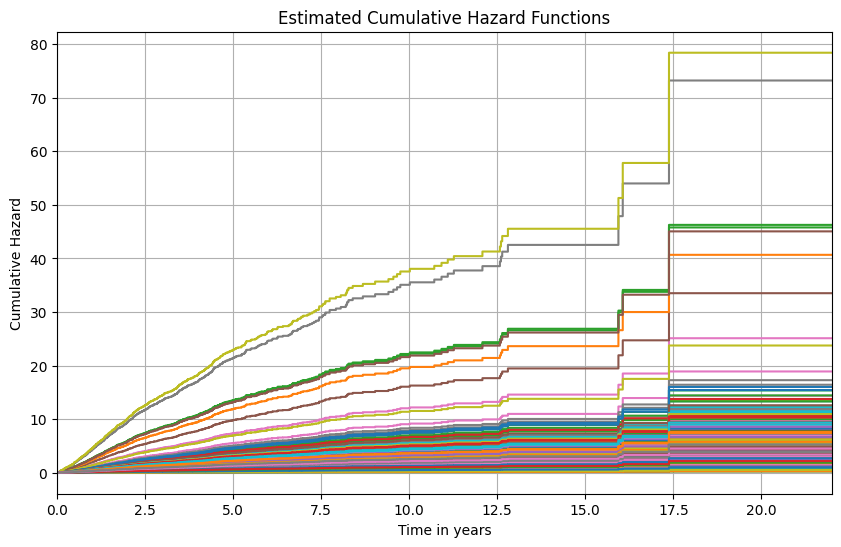

In [ ]:
# visualize the cumulative hazard function

# plot the estimated cumulative hazard functions
plt.figure(figsize=(10, 6))
plt.title("Estimated Cumulative Hazard Functions")
plt.xlabel("Time in years")
plt.ylabel("Cumulative Hazard")
plt.grid(True)  
plt.xlim(0, 22)  # Set x-axis limit to 22 years

for fn in train_chf:
    plt.step(fn.x, fn(fn.x), where = 'post')
plt.legend(["Sample {}".format(i) for i in range()])
plt.show()


In [64]:
# target rms
coxph.score(cox_X_test, cox_y_test) 

np.float64(0.7047842034043159)

In [69]:
# predict on test set
y_pred = coxph.predict(cox_X_test)

In [70]:
# get rmse
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_df["OS_YEARS"], y_pred))
print("RMSE: ", rmse)

RMSE:  5.348839664298931


In [53]:

# Predict the risk scores for the test set
cox_X_test = X_test_df
cox_y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test_df)

risk_scores = coxph.predict(cox_X_test)  # Predict the risk scores for the test set

# print the risk scores for the first 5 samples
print("Risk scores for the first 5 samples:", risk_scores[:5])



Risk scores for the first 5 samples: [-2.37745622 -2.12777911 -1.83960256 -1.27496823 -1.61024574]


## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]



## Concordance index (C-index)

The metric of the C-index evaluates a model by comparing pairs of individuals with the occurence of the event "death" and ranks them accordingly to their predicted risk scores. Correctly ordered pairs are called "concordant".
In the context of right-censored data, the C-index measures the probability of a correctly assigned classifier to a random pair of patients with different probability of event occurence in each individual. 

It is also known as the Harrell's concordance index, and will return values which are biased upwards if there is a high number of censoring in the test data. Therefore the Inversed Probability Censoring Index IPCW is proposed to be the alternative, as it behaves better for highly censored data.

The C-index returns values between 0 and 1, where 0.5 corresponds to a pair with identical predicted risks and is compareable to Area Under Curve (AUC) when the data is complete (not censored)

In [54]:
# scan CYTOGENETICS column for "xx" or "xy", ignore the rest 

# if "xx" appears anywhere in the column, then the patient is female


nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xx", case=True), "Sex"] = "Female"

# if "xy" appears anywhere in the column, then the patient is male
nw_cln_df.loc[nw_cln_df["CYTOGENETICS"].str.contains("xy", case=True), "Sex"] = "Male"

print(nw_cln_df.head())


        ID CENTER  BM_BLAST    WBC  ANC  MONOCYTES    HB    PLT  \
0  P132697    MSK      14.0    2.8  0.2        0.7   7.6  119.0   
1  P132698    MSK       1.0    7.4  2.4        0.1  11.6   42.0   
2  P116889    MSK      15.0    3.7  2.1        0.1  14.2   81.0   
3  P132699    MSK       1.0    3.9  1.9        0.1   8.9   77.0   
4  P132700    MSK       6.0  128.0  9.7        0.9  11.1  195.0   

                          CYTOGENETICS     Sex BM_BLAST_group HB_group  \
0      46,xy,del(20)(q12)[2]/46,xy[18]    Male           High      Low   
1                                46,xx  Female            Low     High   
2   46,xy,t(3;3)(q25;q27)[8]/46,xy[12]    Male           High     High   
3    46,xy,del(3)(q26q27)[15]/46,xy[5]    Male            Low      Low   
4  46,xx,t(3;9)(p13;q22)[10]/46,xx[10]  Female         Medium     High   

  PLT_group  
0    Medium  
1       Low  
2       Low  
3       Low  
4      High  


## Inversed Probability Censoring Weighting (IPCW)

The IPCW is an alternative estimator to the concordance index and does not depend on the distribution of censoring times in the test data. This leads to an unbiased and consistent concordance measure for a population without censoring.

The IPCW represents the inversed probability of censoring weights, while estimating the censoring distribution based on the survival times of the training data.



In [55]:
# prepare data for IPCW evaluation
print(type(y_test_df))

cox_y_test = Surv.from_dataframe("OS_STATUS", "OS_YEARS", y_test_df)

cox_X_test = X_test

<class 'pandas.core.frame.DataFrame'>


In [56]:
# Evaluate the model using Concordance Index IPCW
from sksurv.metrics import concordance_index_ipcw


# Initialize and train the Cox Proportional Hazards model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(cox_X_train, cox_y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(
    cox_y_train, cox_y_train, coxph.predict(cox_X_train), tau=7
)[0]
cox_cindex_test = concordance_index_ipcw(
    cox_y_train, cox_y_test, coxph.predict(cox_X_test), tau=7
)[0]

print(
    "Cox Proportional Hazard Model Concordance Index IPCW on train: {:.2f}".format(
        cox_cindex_train
    )
)
print(
    "Cox Proportional Hazard Model Concordance Index IPCW on test: {:.2f}".format(
        cox_cindex_test
    )
)

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.67


In [57]:
# Evaluate the  model
# Example for a classification problem
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# For a regression problem, you might use:
# mse = mean_squared_error(y_test, y_pred)

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [58]:
# evaluation of different models
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
